In [ ]:
!pip install matplotlib==3.5.3
!pip install seaborn==0.12.0
!pip install pandas==1.5.1
!pip install scipy==1.9.3
!pip install numpy==1.23.4
!pip install plotly==5.11.0

# Giriş

Bu rapor, ABD eyaletlerindeki arı kolonilerinin yıllar içerisinde ne kadar artıp azaldığını ve arı kolonilerini etkileyen stres faktörleri üzerine yapılan veri görselleştirme çalışmalarını içermektedir. Çalışmalar kapsamında arı kolonilerindeki kayıpların coğrafi dağılımı, zamana bağlı koloni sayılarındaki değişimler ve stres faktörleri üzerine görselleştirmeler gerçekleştirilmiştir. 

Görselleştirme araçları olarak zamana bağlı değişimleri göstermek için çizgi grafiklerinden faydalanılırken coğrafi ilişkileri görselleştirebilmek için harita giydirmesi tekniği kullanılmıştır. Coğrafi verilerin zamana bağlı değişimini görselleştirirken animasyon tekniklerinden faydalanılmıştır. Daha detaylı incelemeler yapılabilmesi için grafiklere etkileşimli özellikler de eklenmiştir.

## Veri Seti

Çalışmada kullanılan veri setleri github'da yer alan "R4DS" çevrimiçi öğrenme topluluğuna ait olan "tidytuesday" projesinden alınmıştır. Kullanılan veri setleri "Bee Colonies" adı verilen ana veri setinin alt parçaları olup 2 adet .csv dosyasından oluşmaktadır. Alınan iki veri setine ait bilgiler aşağıda sıralanmıştır.
*   Veri setinin adı: colony.csv [koloni.csv]
 *   Veri setinin nitelik sayısı: 10
 *   Veri setinde yer alan niteliklerin adı: year, months, state, colony_n, colon_max, colony_lost, colony_lost_pcs, colony_added, colony_reno, colony_reno_pct **_[yıl, ay, eyalet, koloni sayısı, maksimum koloni sayısı, kaybolan koloni sayısı, kaybolan koloni yüzesi, eklenen koloni sayısı, yenilenen koloni sayısı, yenilenen koloni yüzdesi]_**

*   Veri setinin adı: stressor.csv [stres_faktörleri.csv]
 *   Veri setinin nitelik sayısı: 5
 *   Veri setinde yer alan niteliklerin adı: year, months, state, stressor, stress_pct **_[yıl, ay, eyalet, stres faktörü, stres faktöründen etkilenen kolonilerin yüzdesi]_**

Görselleştirme çalışmalarına başlamadan önce ABD eyaletlerini temsil eden harita bilgileri farklı bir veri setinden çekilerek orijinal veri setine entegre edilmiştir. Böylece harita giydirme işleminde eyalet sınırları orijinal halleri ile aktarılabilmiştir.

Orijinal veri setinde aşağıdaki eyaletlere ait bilgiler bulunmadığı için bu eyaletlere ait bölgeler görselleştirmede siyah ve tonu renklerde gösterilmiştir. Bu eyaletler:
*   Delaware
*   Nevada
*   Rhode Island
*   New Hampshire'dir.

Görselleştirmenin daha bütünsel görünmesi adına bu eyaletler için geçersiz veriler (101, -1 gibi) girilmesi değerlendirilmiştir. Ancak sadece renk skalası ile inceleme yapan kullanıcıların yanlış bilgilendirilme ihtimali bulunduğu için bu uygulama gerçekleştirilmemiştir.




In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from urllib.request import urlopen
import json
import plotly.express as px

# İstatistiksel Veri İncelemesi

Yukarıdaki başlıkta bahsedilen veri setlerinin çevrimiçi adreslerden okunarak colab ortamında bir değişkene atınması işlemleri ile çalışmaya başlanılmıştır. Veri okuma işleri tamamlandıktan sonra eyalet bilgisi ile lokasyon bilgileri eşlenerek orijinal veri setleri genişletilmiştir. 

Veri setleri içerisinde yer alan sayısal veriler istatistiksel özet bilgiler aracılığı ile incelenmiştir. Bu incelemedeki temel motivasyon veri seti içerisinde fiziken imkansız verilerin olup olmadığının kontrol edilmesidir. Örneğin koloni sayısı için negatif bir sayı veri setinde hatalı işlemeye işaret gösterebileceği için bu inceleme sonrasında veri setinden çıkarılmalıdır.

Koloniler hakkında bilgilerin yer aldığı veri seti bu amaç doğrultusunda kontrol edildiğinde veri seti içerisinde tutarsız bir veri noktasına rastlanmamıştır. 

Stres faktörü veri setinde yapılan inceleme sonrasında veri setinde %102 gibi fiziken anlamsız bir veri girişine rastlanmıştır. Bu veri satırı veri setinin tutarlılığı için silinmiştir.

In [46]:
# Mekansal görselleştirme için gerekli ABD'ye ait GeoJSON dosyasının okunması
with urlopen('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json') as response:
    states_of_USA = json.load(response)

In [47]:
# GeoJSON bilgisinin elimizdeki df ile eşlenebilmesi için gerekli bilgilerin GeoJSON dosyasından ayıklanması
states_code_name = {
    "state": [],
    "id": []
}
for state in states_of_USA["features"]:
    states_code_name["state"].append(state["properties"]["name"])
    states_code_name["id"].append(state["id"])

states_code_name = pd.DataFrame(states_code_name)

In [48]:
# Ana verisetlerinin URL üzerinden okunarak df'lere aktarılması
colony_df = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-01-11/colony.csv")
stressor_df = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-01-11/stressor.csv")

In [49]:
# GeoJSON ve df'lerin eşlenebilmesi için gerekli olan birleştirme işleminin yapılması
colony_df = pd.merge(colony_df, states_code_name, how="left", on="state", indicator=True)

stressor_df = pd.merge(stressor_df, states_code_name, how="left", on="state", indicator=True)

In [50]:
colony_df.describe()

,year,colony_n,colony_max,colony_lost,colony_lost_pct,colony_added,colony_reno,colony_reno_pct
count,1222.000000,1.175000e+03,1.150000e+03,1175.000000,1168.000000,1139.000000,1091.000000,962.000000
mean,2017.769231,1.235780e+05,7.911277e+04,16551.319149,11.381849,17243.195786,15278.863428,9.097713
std,1.888133,4.378352e+05,1.908234e+05,60544.422405,7.225804,68167.652332,62588.044884,9.659813
min,2015.000000,1.300000e+03,1.700000e+03,20.000000,1.000000,10.000000,10.000000,1.000000
25%,2016.000000,8.000000e+03,9.000000e+03,950.000000,6.000000,420.000000,260.000000,2.000000
50%,2018.000000,1.750000e+04,2.100000e+04,2200.000000,10.000000,1800.000000,960.000000,6.000000
75%,2019.000000,5.550000e+04,6.875000e+04,6500.000000,15.000000,6500.000000,4585.000000,12.000000
max,2021.000000,3.181180e+06,1.710000e+06,502350.000000,52.000000,736920.000000,806170.000000,77.000000


In [51]:
stressor_df.describe()

,year,stress_pct
count,7332.000000,6489.000000
mean,2017.769231,11.204007
std,1.887489,14.866204
min,2015.000000,0.100000
25%,2016.000000,1.700000
50%,2018.000000,5.300000
75%,2019.000000,14.200000
max,2021.000000,102.000000


In [52]:
stressor_df[stressor_df["stress_pct"] > 99]

,year,months,state,stressor,stress_pct,id,_merge
4590,2019,January-March,Kansas,Varroa mites,102.0,20,both


In [53]:
stressor_df.drop(index=4590, inplace=True)

#Ön Hazırlık

Zamana bağlı görselleştirmelerde kullanılacak kütüphanelere daha uyumlu nitelikler kullanmak adıyla "months" niteliği revize edilerek çeyreklik bilgisi veri setine eklenmiştir. Daha sonra bu çeyreklik verisi yıl bilgisi ile birleştirilerek görselleştirme kütüphanelerinin de işleyebileceği bir zaman tanımı veri setine eklenmiştir.

Ek olarak, görselleştirme üzerinde yer alan etiketlerin türkçeleştirilmesi için değişiklikler gerçekleştirilmiştir.

Son olarak coğrafi bilgilerin yıllık olarak görselleştirilebilmesi için veri setinde gruplama operasyonu gerçekleştirilmiştir.

In [54]:
# Zamansal veri ile yapılacak işlemleri kolaylaştırmak için çeyrek-yıl bilgisinin df üzerinden türetilerek df'ye eklenmesi
colony_df["quarter"] = colony_df["months"]
colony_df.replace({
    "quarter": {
        "January-March": 1,
        "April-June": 2,
        "July-September": 3,
        "October-December": 4
    }
}, inplace=True)
colony_df["Quarter"] = pd.PeriodIndex(year=colony_df["year"], quarter=colony_df["quarter"]).strftime("%m-%Y")
colony_df.drop(columns="quarter", inplace=True)
#colony_df[colony_df["state"] == "Alabama"].head(10)

In [55]:
# Zamansal veri ile yapılacak işlemleri kolaylaştırmak için çeyrek-yıl bilgisinin df üzerinden türetilerek df'ye eklenmesi
stressor_df["quarter"] = stressor_df["months"]
stressor_df.replace({
    "quarter": {
        "January-March": 1,
        "April-June": 2,
        "July-September": 3,
        "October-December": 4
    }
}, inplace=True)
stressor_df["Quarter"] = pd.PeriodIndex(year=stressor_df["year"], quarter=stressor_df["quarter"]).strftime("%m-%Y")
stressor_df.drop(columns="quarter", inplace=True)

# Görselleştirme için stres etkenlerinin türkçeleştirilmesi
stressor_df.replace({
    "stressor": {
        "Varroa mites": "Varroa Akarları",
        "Other pests/parasites": "Diğer Haşereler/Parazitler",
        "Disesases": "Hastalıklar",
        "Pesticides": "Tarım İlacı",
        "Other": "Diğer",
        "Unknown": "Bilinmeyen"
    }
}, inplace=True)

stressor_df.rename(columns={"stressor": "Stres Faktörü"}, inplace=True)
#stressor_df[stressor_df["state"] == "United States"].head(10)

In [56]:
# Koloniler hakkındaki çeyrek-yıllık bilgilerin yıllık olarak bir araya getirilmesi
yearly_colony_information = colony_df[colony_df["_merge"] == "both"]\
    .drop(columns=["months", "colony_n", "colony_max", "colony_reno_pct", "_merge", "Quarter", "id"])\
        .groupby(["year", "state"])\
            .agg(np.mean)\
                .reset_index()

yearly_colony_information = pd.merge(yearly_colony_information, states_code_name, how="left", on="state", indicator=True).rename(columns={"year": "Yıl"})
#yearly_colony_information.sort_values(by="colony_lost", ascending=False)

# Veri Analizi

Arı gibi canlı varlıkların sayısı bulundukları coğrafyaya bağlı olabilecek bir parametredir. Örneğin bazı eyaletlerin fazla soğuk geçen kış aylarına sahip olması o eyaletteki arı kaybının daha yüksek oranda olmasına sebep olabilir. Dolayısıyla veri analizine coğrafi konuma bağlı arı ölümlerinin incelenmesi ile başlanmıştır.

## Soru 1: Coğrafi Bölgenin Arı Kaybı İle İlişkisi Var Mıdır?

Aşağıdaki grafikte ABD eyaletlerindeki arı kolonilerinde kaybın yüzdesel karşılığı ABD siyasi haritası üzerinde "choropleth map" tipi bir görselleştirme tipi aracılığı ile görselleştirilmiştir. Ek olarak coğrafi dağılımın (örn batı veya doğu) yıllar içerisinde nasıl değiştiğinin de görselle eklenebilmesi için animasyon tekniğinden faydalanılmıştır.

In [63]:
fig = px.choropleth_mapbox(yearly_colony_information, geojson=states_of_USA, locations='id', color='colony_lost_pct',
                           hover_name="state",
                           hover_data={"Yıl": False, "id": False, "colony_lost": True, "colony_added": True, "colony_reno": True},
                           color_continuous_scale="reds",
                           mapbox_style="carto-darkmatter",
                           range_color=(0, 30),
                           zoom=3.75, center = {"lat": 39, "lon": -95.7129},
                           opacity=0.5,
                           labels={'colony_lost':'Kaybedilen Koloniler', "colony_added": "Eklenen Koloniler", "colony_reno": "Restore Edilen Koloniler", "colony_lost_pct": "Kaybolan Koloni Yüzdesi"},
                           animation_frame="Yıl",
                           animation_group="state",
                           title="Yıllara Göre Eyaletlerde Gerçekleşen Kaybedilen Kolonilerin Yüzdesel Dağılımı [2015-2021]",
                           width=1650,
                           height=800
                          )
fig.update_layout(
    margin={"r":0,"t":30,"l":0,"b":0},
    font_family="Courier New",
    title_font_family="Times New Roman",
    font_size=16
    )
fig.update_xaxes(title_font_family="Arial")
fig.show()

Bulgular: 2015-2021 yılları arasındaki arı kolonilerinde yüzdesel kayıp coğrafi konumlarına bağlı olarak görselleştirildiğinde keskin bir şekilde koloni kayıplarının odaklandığı bir bölge görülememiştir. Ancak cografi konum üzerine giydirilmiş ısı haritasının ABD'nin orta enleminde (Kansas-Arizona) bir miktar daha yoğun olduğu değerlendirilmiştir. Bu da ABD için Kansas ve Arizona üzerinden geçen enlem üzerinde arı koloni kaybının ABD genelinden biraz daha fazla olduğunu göstermektedir.

* İşaretliyici: 

 * Eyalet Siyasi Alanları

* Kanallar:

 * X: Boylam (Kantitatif)
 * Y: Enlem (Kantitatif)
 * Renk: Kaybolan Koloni Yüzdesi (Kantitatif)
 * Animasyon Dilimleri: Verinin Toplandığı Yıl (Sıralı)
 * Not Kutusu: Animasyon diliminin çizildiği yılda ilgili coğrafi konuma ait kategorik kantitatif olan diğer bilgiler

## Soru 2: ABD Genelinde Zamana Bağlı Koloni Artış ve Azalış Sayılarındaki Değişim

Coğrafi olarak arı kolonilerindeki yüzdesel kaybın ABD'nin belli eyaletlerinde net bir şekilde öbeklenmediğinin ve orta-güney enlemlerde göreceli olarak daha fazla kaybın gözlemlenmesi üzerine ABD genelindeki arı kolonilerinin artış ve azalış miktarları incelenmiştir.

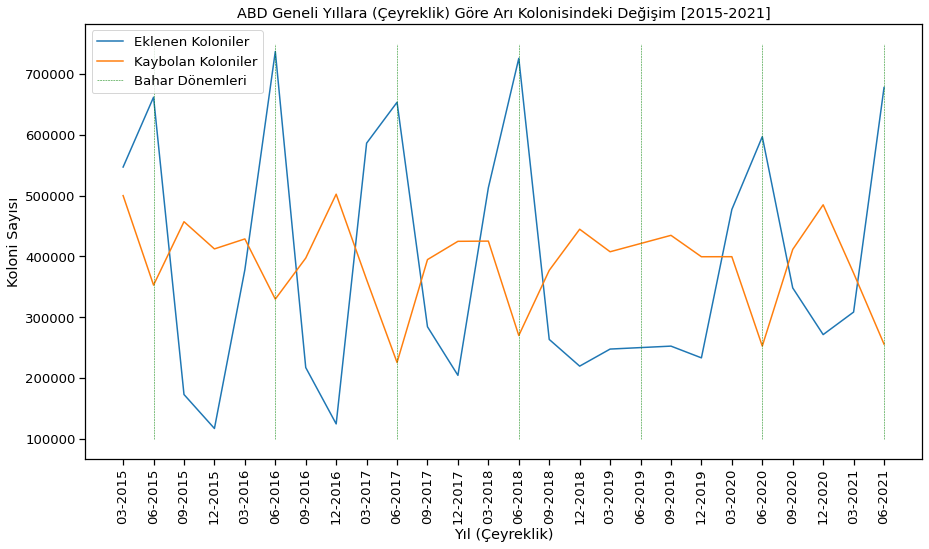

In [58]:
sns.set_context("notebook", font_scale=1.2)
fig, ax = plt.subplots()

sns.lineplot(colony_df[colony_df["state"] == "United States"], x="Quarter", y="colony_added", errorbar=None, ax=ax, label="Eklenen Koloniler")
sns.lineplot(colony_df[colony_df["state"] == "United States"], x="Quarter", y="colony_lost", errorbar=None, ax=ax, label="Kaybolan Koloniler")

ax.tick_params(axis="x", rotation=90)
ax.set_xlabel("Yıl (Çeyreklik)")
ax.set_ylabel("Koloni Sayısı")
ax.set_title("ABD Geneli Yıllara (Çeyreklik) Göre Arı Kolonisindeki Değişim [2015-2021]")

spring_period=["06-2015", "06-2016", "06-2017", "06-2018", "06-2019", "06-2020", "06-2021"]
for count, period in enumerate(spring_period):
  if count:
    ax.vlines(ymin=1e5, ymax=7.5e5, x=period, color="green", linestyles="dashed", linewidths=0.5)
  else:
    ax.vlines(ymin=1e5, ymax=7.5e5, x=period, color="green", linestyles="dashed", linewidths=0.5, label="Bahar Dönemleri")


ax.legend()

fig.set_size_inches(15, 8)

ABD genelindeki koloni sayılarının artış ve azalış grafikleri zamana bağlı görselleştirildiğinde açık bir şekilde değişimin mevsimsel olduğu görülmüştür. Her bahar döneminde (Nisan-Haziran) koloni sayılarında ciddi bir ***artış*** olduğu görülmektedir. Yalnızca 2019 yılı baharında periyodik artış gözlemlenememiştir ancak veri setine bakıldığında (detaylar aşağıda paylaşılmıştır.) 2019 yılı baharındaki bütün verilerin "NaN" değerine sahip olduğu görülmüştür. Öte yandan her kış mevsiminde de (Ekim-Aralık) koloni sayılarındaki ***düşüşün*** en yüksek değerlere ulaştığı görülmüştür.

* İşaretliyici: 

 * Çizgi

* Kanallar:

 * X: Yıl (Çeyreklik) (Sıralı)
 * Y: Koloni Sayısı (Kantitatif)
 * Renk: Eklenen veya Kaybolan Koloni Sayısı (Kategorik)
 * Dikey Not Çizgileri: Bahar Dönemleri (Kategorik)

In [59]:
colony_df[colony_df["Quarter"] == "06-2019"].shape

(47, 13)

In [60]:
colony_df[colony_df["Quarter"] == "06-2019"].isna().sum()

year                0
months              0
state               0
colony_n           47
colony_max         47
colony_lost        47
colony_lost_pct    47
colony_added       47
colony_reno        47
colony_reno_pct    47
id                  2
_merge              0
Quarter             0
dtype: int64

## Soru 3: Arıları En Çok Etkileyen Stres Faktörü Nedir?



Arı kolonilerindeki düşüşün periyodik bir olgu olduğunun gözlemlenmesinin ardından ikinci veri seti de kullanılarak arı ölümlerinin temel sebebinin ne olabileceği üzerine bir görselleştirme oluşturulmuştur. Bu kapsamda stres faktörleri en çok arı ölümünün (yüzdesel) gerçekleştiği 5 eyalet ve bütün ABD için zamana bağlı olarak görselleştirilmiştir.

In [61]:
highest_colony_losses = list(yearly_colony_information[["state", "colony_lost", "colony_lost_pct"]].groupby("state").agg(np.mean).nlargest(5, "colony_lost_pct").index.values)

In [65]:
highest_colony_losses.append("United States")
stressor_df.rename(columns={"state":"Eyalet", "Quarter": "Çeyreklik", "stress_pct": "Stres Yüzdesi"}, inplace=True)
filtered_stressor_df = stressor_df[stressor_df["Eyalet"].isin(highest_colony_losses)]

fig = px.line(data_frame=filtered_stressor_df, x="Çeyreklik", y="Stres Yüzdesi", color="Stres Faktörü", facet_col="Eyalet", facet_col_wrap=3, height=750, 
                labels={
                  "Çeyreklik": "Yıl(Çeyreklik)"
                 }, title="En Çok Arı Kolonisinin Kaybolduğu 5 Eyaletteki ve ABD Genelinde Arı Kolonilerini Etkileyen Stres Faktörleri [2015-2021]")

fig.update_traces(connectgaps=True)

for count, period in enumerate(spring_period):
  if count == 1:
    fig.add_vline(x=period, line_width=0.5, line_dash="dash", line_color="green")
    fig.add_annotation(x=period, text="Bahar <br> Dönemleri", xref="x4", yref="y4", yshift=190, arrowcolor="green",
                           font=dict(color="green"), arrowhead=5, arrowsize=1, arrowwidth=1, ax=-30, ay=-30)

  fig.add_vline(x=period, line_width=0.5, line_dash="dash", line_color="green")

fig.show()


Yapılan görselleştirmelerde eyaletten bağımsız olarak kolonilerin en çok maruz kaldığı stres faktörünün "Varroa Akarı" olarak isimlendirilen organizmalar olduğu ortaya çıkmıştır. Alabama özelinde ise Varroa Akar'ı kadar diğer haşerat ve parazitlerinde koloniler üzerinde yüksek oranda bir strese sebep olduğu görülmüştür.

Koloni sayılarındaki artış ve azalış mevsimsel olarak periyodik bir değişim gösterdiği için stres faktörleri için de benzer bir davranış olup olmadığı bahar dönemi referans alınarak incelenmiştir. Ancak bütün eyaletler (en çok kayıp yüzdesinin olduğu 5 eyalette) için geçerli olan periyodik bir davranış gözlemlenememiştir. ABD geneline bakıldığında ise bahar dönemi öncesi [Ocak-Mart] Varroa Akar'larının etkilediği koloni sayısının genelde azaldığı görülmüştür. _[2019 yılı verilerinin "NaN" olduğu daha önce belirtilmiştir.]_ Bu durumun akarların, bahar ayları öncesinde, kolonileri daha az etkilemesinden ötürü bahar ayına kadar koloni sayılarında artışa sebep olduğu değerlendirilmiştir. 

* İşaretliyici: 

 * Çizgi

* Kanallar:

 * X: Yıl (Çeyreklik) (Sıralı)
 * Y: Stres Yüzdesi (Kantitatif)
 * Renk: Stres Tipi (Kategorik)
 * Dikey Not Çizgileri: Bahar Dönemleri (Kategorik)

# Sonuç ve Değerlendirme

Bu çalışma kapsamında ABD genelinde yer alan arı kolonilerinin kaybı ve kolonilere etki eden stres faktörleri hakkında incelemeler gerçekleştirilmiştir.

İlk olarak arı kayıplarının coğrafi lokasyon ile ilgili olup olmadığının anlaşılabilmesi için harita giydirme yönteminden faydalanılarak eyaletlere ait kayıp bilgileri ABD haritası üzerinde görselleştirilmiştir. Bu incelemede Kansas ve Arizona enlemi boyunca koloni kaybının göreceli olarak daha fazla olduğu görülmüştür.

Daha sonra koloni sayısındaki artış ve azalış verisi zaman serisi olarak bir çizgi grafiğinde görselleştirilmiştir. Bu görselleştirmede çok belirgin bir şekilde artış ve azalışın mevsimsel olarak periyodik bir davranışa sahip olduğu görülmüştür.

Son olarak en çok koloni kaybının gerçekleştiği 5 eyalette stres faktörlerinin dağılım incelenmiş olup en etken faktörün Varroa Akar'ları olduğu görülmüş olup bunun ABD geneli için de geçerli olduğu görülmüştür. Ek olarak, ABD geneli için Varroa Akar'larının etkilediği koloni sayısının da periyodik olduğu değerlendirilmiştir.

Bu çalışma sonucunda ABD'de arıcılık ile uğraşan insanların akarlara karşı ciddi önlemler alması gerektiği ve kuzey ABD'nin arıcılık için daha elverişli olduğu değerlendirilmiştir.